In [1]:
import torch, time, warnings, os
warnings.filterwarnings("ignore")
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [3]:
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [4]:
root = "/kaggle/input/cats-dogs/CATS_DOGS/"

train_data = datasets.ImageFolder(os.path.join(root,'train'),transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(root,'test'),transform=test_transforms)

In [5]:
torch.manual_seed(64)

train_loader = DataLoader(dataset=train_data,batch_size=25,shuffle=True)
test_loader = DataLoader(dataset=test_data,batch_size=25,shuffle=False)

class_names = train_data.classes

In [6]:
class_names

['CAT', 'DOG']

In [7]:
len(train_data), len(test_data)

(18743, 6251)

In [8]:
for images, labels in train_loader:
    break

In [9]:
images.shape

torch.Size([25, 3, 224, 224])

In [10]:
labels.shape

torch.Size([25])

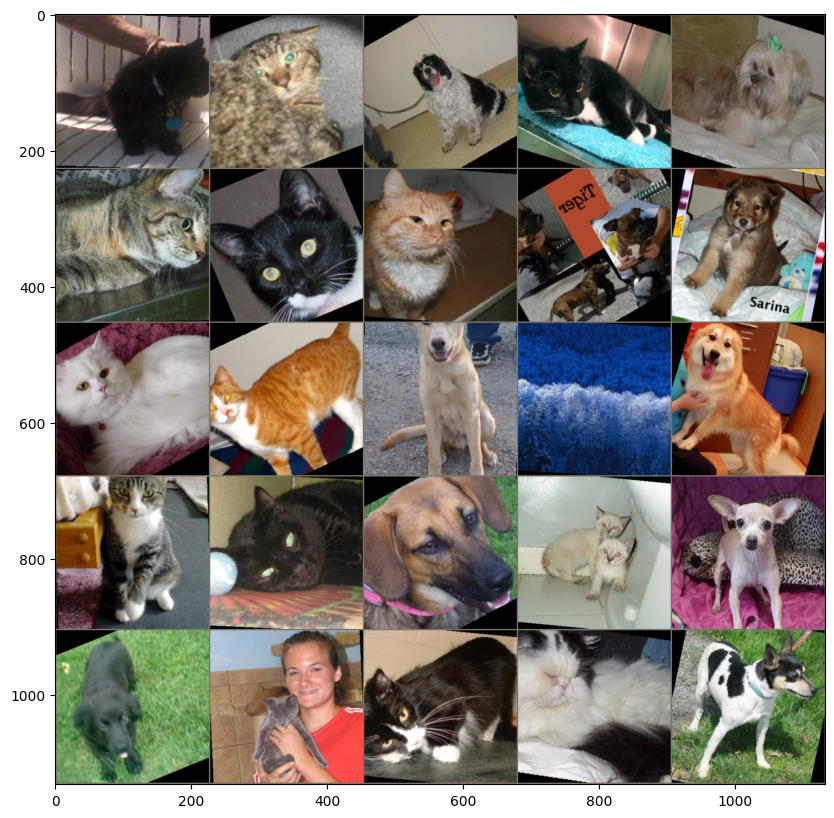

In [11]:
im = make_grid(images,nrow=5)

inv_normalize = transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],std=[1/0.229,1/0.224,1/0.225])
inv_img = inv_normalize(im)

plt.figure(figsize=(20,10))
plt.imshow(np.transpose(inv_img.numpy(),(1,2,0)));

In [12]:
((54-3+1)/1)/2

26.0

In [13]:
class ConvolutionalNeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1) # 111,111,8
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1) # 54,54,16
        self.conv3 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1) # 26,26,32
        self.fc1 = nn.Linear(in_features=26*26*32,out_features=64)
        self.fc2 = nn.Linear(in_features=64,out_features=32)
        self.fc3 = nn.Linear(in_features=32,out_features=2)

    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,kernel_size=2,stride=2)
        X = X.view(-1,26*26*32)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)

In [14]:
torch.manual_seed(64)

model = ConvolutionalNeuralNetwork()
model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [15]:
total_parameters = 0

for param in model.parameters():
    print(param.numel())
    total_parameters += param.numel()

print("Total CNN model parameters:",total_parameters)

216
8
1152
16
4608
32
1384448
64
2048
32
64
2
Total CNN model parameters: 1392690


In [16]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [17]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [18]:
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

# Set limit on number of batches
max_train_batch_sz = 900
max_test_batch_sz = 400

for i in range(epochs):
    train_correct = 0
    test_correct = 0

    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        if batch_no == max_train_batch_sz: # Optional
            break

        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_no % 200 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")

    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())

    with torch.no_grad():
        for batch_no, (X_test, y_test) in enumerate(test_loader):
    
            if batch_no == max_test_batch_sz: # Optional
                break
    
            y_pred = model(X_test)
            predicted = torch.max(y_pred,1)[1]
            test_correct += (predicted == y_test).sum()

    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
        
print(f"Total time elapsed in CNN model training: {(time.time()-start_time)/60} minutes")

Epoch 0 Batch 200 -> Loss: 0.616314172744751
Epoch 0 Batch 400 -> Loss: 0.6089471578598022
Epoch 0 Batch 600 -> Loss: 0.6044793128967285
Epoch 1 Batch 200 -> Loss: 0.4474426507949829
Epoch 1 Batch 400 -> Loss: 0.38671278953552246
Epoch 1 Batch 600 -> Loss: 0.5693532824516296
Epoch 2 Batch 200 -> Loss: 0.6357531547546387
Epoch 2 Batch 400 -> Loss: 0.5017555356025696
Epoch 2 Batch 600 -> Loss: 0.4125003516674042
Epoch 3 Batch 200 -> Loss: 0.4142647683620453
Epoch 3 Batch 400 -> Loss: 0.3631930649280548
Epoch 3 Batch 600 -> Loss: 0.48232853412628174
Epoch 4 Batch 200 -> Loss: 0.3492462933063507
Epoch 4 Batch 400 -> Loss: 0.2800368666648865
Epoch 4 Batch 600 -> Loss: 0.48952051997184753
Epoch 5 Batch 200 -> Loss: 0.49926722049713135
Epoch 5 Batch 400 -> Loss: 0.38991597294807434
Epoch 5 Batch 600 -> Loss: 0.29934635758399963
Epoch 6 Batch 200 -> Loss: 0.34072884917259216
Epoch 6 Batch 400 -> Loss: 0.4083119332790375
Epoch 6 Batch 600 -> Loss: 0.4519311487674713
Epoch 7 Batch 200 -> Loss: 0

In [19]:
torch.save(model.state_dict(),'cat_dog_classifier.pt')

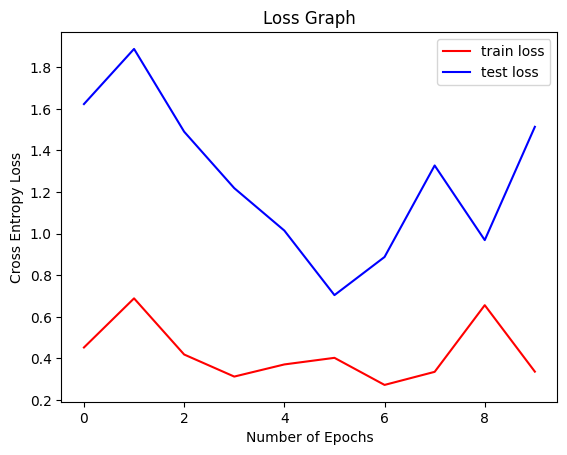

In [21]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend();

In [31]:
train_correct_predictions, test_correct_predictions

([12399, 14022, 14615, 14924, 15097, 15294, 15467, 15773, 15782, 15855],
 [4565, 4924, 4978, 5101, 5075, 5103, 5229, 5285, 5312, 5231])

In [35]:
train_accuracies = [x/180 for x in train_correct_predictions]
test_accuracies = [x/80 for x in test_correct_predictions]

In [36]:
train_accuracies, test_accuracies

([68.88333333333334,
  77.9,
  81.19444444444444,
  82.91111111111111,
  83.87222222222222,
  84.96666666666667,
  85.92777777777778,
  87.62777777777778,
  87.67777777777778,
  88.08333333333333],
 [57.0625,
  61.55,
  62.225,
  63.7625,
  63.4375,
  63.7875,
  65.3625,
  66.0625,
  66.4,
  65.3875])

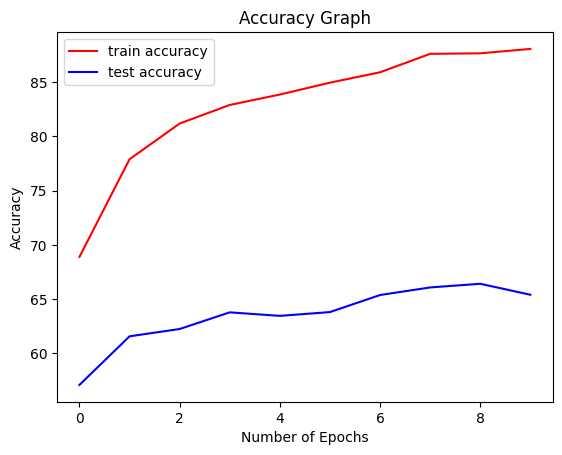

In [37]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [18]:
alexnet = models.alexnet(pretrained=True)
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 176MB/s]  


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
for param in alexnet.parameters():
    param.requires_grad = False
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
37748736
4096
16777216
4096
4096000
1000


In [23]:
total_alexnet_params = 0

for param in alexnet.parameters():
    total_alexnet_params += param.numel()

print(total_alexnet_params)

61100840


In [26]:
alexnet.classifier = nn.Sequential(
    nn.Linear(9216,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,2),
    nn.LogSoftmax(dim=1)
)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.classifier.parameters(),lr=0.001)

In [30]:
start_time = time.time()

epochs = 10

max_train_batch_limit = 900
max_test_batch_limit = 400

train_losses = []
test_losses = []
train_correct_predictions = []
test_correct_predictions = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0
    
    for batch_no, (X_train, y_train) in enumerate(train_loader):
        batch_no += 1
        
        if batch_no == max_train_batch_limit:
            break
            
        y_pred = alexnet(X_train)
        loss = criterion(y_pred,y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_correct_predictions = (predicted == y_train).sum()
        train_correct += batch_correct_predictions
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_no % 200 == 0:
            print(f"Epoch {i} Batch {batch_no} -> Loss: {loss.item()}")
    
    train_losses.append(loss.item())
    train_correct_predictions.append(train_correct.item())
    
    for batch_no, (X_test, y_test) in enumerate(test_loader):
        
        if batch_no == max_test_batch_limit:
            break
            
        y_pred = alexnet(X_test)
        predicted = torch.max(y_pred,1)[1]
        test_correct += (predicted == y_test).sum()
    
    loss = criterion(y_pred,y_test)
    test_losses.append(loss.item())
    test_correct_predictions.append(test_correct.item())
    
print(f"Total time elapsed in Alexnet model training: {(time.time() - start_time)/60} minutes.")

Epoch 0 Batch 200 -> Loss: 0.19724945724010468
Epoch 0 Batch 400 -> Loss: 0.009156406857073307
Epoch 0 Batch 600 -> Loss: 0.21400953829288483
Epoch 1 Batch 200 -> Loss: 0.26746368408203125
Epoch 1 Batch 400 -> Loss: 0.11526221036911011
Epoch 1 Batch 600 -> Loss: 0.31242039799690247
Epoch 2 Batch 200 -> Loss: 0.19755735993385315
Epoch 2 Batch 400 -> Loss: 0.2754708528518677
Epoch 2 Batch 600 -> Loss: 0.03960264101624489
Epoch 3 Batch 200 -> Loss: 0.18136201798915863
Epoch 3 Batch 400 -> Loss: 0.2762041389942169
Epoch 3 Batch 600 -> Loss: 0.30393514037132263
Epoch 4 Batch 200 -> Loss: 0.11107996106147766
Epoch 4 Batch 400 -> Loss: 0.043111491948366165
Epoch 4 Batch 600 -> Loss: 0.11350215971469879
Epoch 5 Batch 200 -> Loss: 0.03259258344769478
Epoch 5 Batch 400 -> Loss: 0.2534288167953491
Epoch 5 Batch 600 -> Loss: 0.05893999710679054
Epoch 6 Batch 200 -> Loss: 0.057285379618406296
Epoch 6 Batch 400 -> Loss: 0.224530890583992
Epoch 6 Batch 600 -> Loss: 0.11311312019824982
Epoch 7 Batch 2

In [31]:
torch.save(alexnet.state_dict(),'cat_dog_alexnet_classifier.pt')

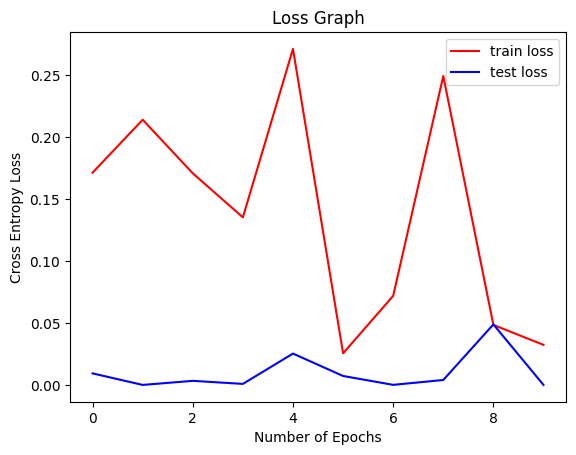

In [32]:
plt.plot(train_losses,'r',label='train loss')
plt.plot(test_losses,'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss Graph')
plt.legend();

In [33]:
train_accuracies = [x/180 for x in train_correct_predictions]
test_accuracies = [x/80 for x in test_correct_predictions]

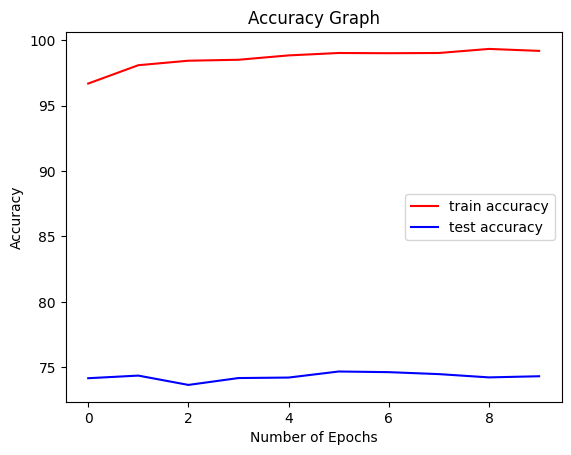

In [34]:
plt.plot(train_accuracies,'r',label='train accuracy')
plt.plot(test_accuracies,'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

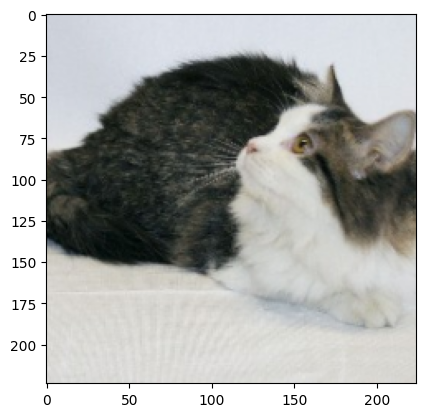

In [39]:
img_idx = 2019

inv_img = inv_normalize(test_data[img_idx][0])
plt.imshow(np.transpose(inv_img,(1,2,0)));

In [40]:
model.eval()

with torch.no_grad():
    pred = model(test_data[img_idx][0].view(1,3,224,224)).argmax()

print(class_names[pred.item()])

CAT


In [41]:
alexnet.eval()

with torch.no_grad():
    pred = alexnet(test_data[img_idx][0].view(1,3,224,224)).argmax()
    
print(class_names[pred.item()])

CAT


CNN model prediction: CAT
Alexnet model prediction: DOG


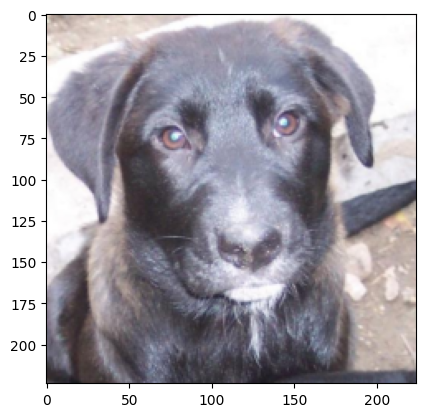

In [45]:
random_img_idx = np.random.randint(0,len(test_data))

inv_img = inv_normalize(test_data[random_img_idx][0])

plt.imshow(np.transpose(inv_img,(1,2,0)))

model.eval()
alexnet.eval()

with torch.no_grad():
    cnn_pred = model(test_data[random_img_idx][0].view(1,3,224,224)).argmax()
    print("CNN model prediction:", class_names[cnn_pred.item()])
    alexnet_pred = alexnet(test_data[random_img_idx][0].view(1,3,224,224)).argmax()
    print("Alexnet model prediction:", class_names[alexnet_pred.item()])